In [1]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

In [2]:
geodata = pd.read_csv('CommunityClubsTest-clean.csv')
print(geodata)
bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
print(bloodbankcoords)

            Y           X     Name
0    1.427493  103.792241    kml_1
1    1.354658  103.889546    kml_2
2    1.397128  103.886666    kml_3
3    1.366833  103.840668    kml_4
4    1.320799  103.747540    kml_5
..        ...         ...      ...
120  1.339973  103.737066  kml_121
121  1.386807  103.771521  kml_122
122  1.341263  103.933010  kml_123
123  1.311728  103.952223  kml_124
124  1.339360  103.727300  kml_125

[125 rows x 3 columns]
       Blood Bank  Postal Code  Latitude   Longitude
0             HSA       169078  1.281335  103.838482
1     Dhoby Ghaut       238826  1.299755  103.846084
2  Westgate Tower       608531  1.335374  103.743005
3       Woodlands       730900  1.436139  103.787195
4     One Punggol       828629  1.408468  103.905039


In [3]:
# y-coordinates/latitude of CCs and BBs
y_coordCC = geodata['Y']
y_coordBB = bloodbankcoords['Latitude']

# x-coordinates/longitude of CCs and BBs
x_coordCC = geodata['X']
x_coordBB = bloodbankcoords['Longitude']

#no. of BBs
nbrblood = 5

#no. of CCs
nbrcomm = 125

#radius of earth
R = 6371


def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# distance calculations between CC and BBs
distancelct=np.empty([nbrblood, nbrcomm])
for i_index in range(nbrblood):
    for j_index in range(nbrcomm):
        d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
        d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
        a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distancelct[i_index,j_index] = R*c

print(distancelct)

[[1.62983199e+01 8.26590280e+00 1.29394220e+01 9.50717786e+00
  5.00689545e+00 5.43578204e+00 6.44300145e+00 7.58764858e+00
  8.17363056e+00 7.86046128e+00 1.14428299e+01 8.02723195e+00
  7.81813030e+00 7.43194037e-01 1.07288287e+01 6.81401263e+00
  3.33524796e+00 3.23571747e+00 1.82106360e+01 7.72756572e+00
  1.00614038e+01 1.66251696e+01 1.13344084e+01 1.04985128e+01
  4.56619666e+00 2.77526169e+00 6.05100040e+00 6.10142290e+00
  6.08268778e+00 1.23176604e+01 1.65649038e+01 1.69527481e+00
  1.18569748e+01 1.97601464e+01 8.35295503e+00 4.20059615e+00
  3.92546738e+00 6.57862029e-01 9.17948424e+00 8.95899829e+00
  9.38767232e+00 1.03026548e+01 5.94717451e-01 3.02966682e+00
  3.39166177e+00 8.25992473e+00 8.10243742e+00 6.24912164e+00
  4.10461572e+00 5.65181442e+00 2.47816418e+00 5.05381684e+00
  4.38605478e+00 2.47060238e+00 1.16891904e+01 1.01935457e+01
  9.50964057e-01 4.83327174e+00 1.21567791e-01 1.13629607e+00
  1.28719975e+01 4.85001883e+00 3.22717498e+00 1.77991958e+01
  8.9851

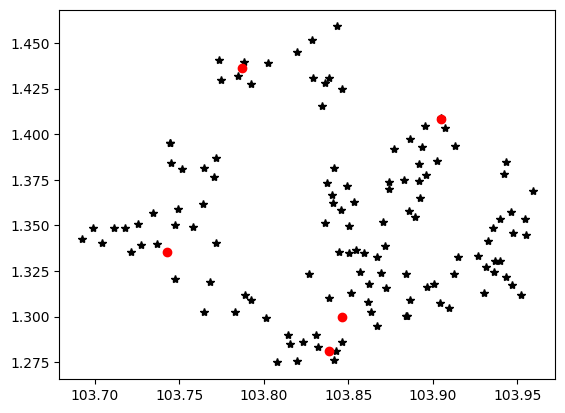

In [4]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');

In [5]:
model = gp.Model("bloodp_pmedian")



Set parameter Username
Set parameter LicenseID to value 2668971
Academic license - for non-commercial use only - expires 2026-05-21
